In [5]:
# The code was run in google colab. It needs to mount the drive firstly
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install libpysal -q
!pip install pysal -q
!pip install statsmodels -q
!pip install sklearn -q
# !pip install segregation -q
!pip install shap -q
!pip install ipdb

In [7]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Prepare Data and Variables

In [9]:
gdf_SVI = gpd.read_file("/content/drive/MyDrive/Vulnerable Wells/demo/data3/0505/IA_SVI_tract_4326.shp", crs=4326)
# Convert to equaldistant projected coordinate system: Equidistant Conic
gdf_SVI_ed = gdf_SVI.to_crs('+proj=eqdc +lon_0=-93.4277344 +lat_1=40.7162992 +lat_2=43.1347415 +lat_0=41.9255204 +datum=WGS84 +units=m +no_defs')
gdf_SVI = gdf_SVI_ed

In [11]:
# set variable for statistics
variables_SVI = [
 '18_POPDEN',
 '18_QWHITE',
 '18_QBLACK',
 '18_QHISP',
 '18_QAGED65',
 '18_QUNEMPL',
 '18_QPOVTY',
 '18_QESL',
 '18_QNOBD'
 ]
X_vars = variables_SVI

nitrate_m = '0418_nmean'
variables_exposure = [nitrate_m]

# centroids
variables_coord = ['x_coord','y_coord']
gdf_SVI['x_coord'] = gdf_SVI.geometry.centroid.x
gdf_SVI['y_coord'] = gdf_SVI.geometry.centroid.y

disease_variable = '14_18_rr'
disease_variable_100 = '14_18_rr_100'
gdf_SVI[disease_variable] = gdf_SVI[disease_variable].astype(float)
gdf_SVI[disease_variable_100] = gdf_SVI[disease_variable]*100

In [14]:
# exclude tracts with population < 500 to avoid small sample bias in ACS dataset
gdf_SVI = gdf_SVI[gdf_SVI['18_Total_P'] > 500]

# drop the tracts with missing nitrate test result
gdf_SVI = gdf_SVI[gdf_SVI[nitrate_m] != 0]

# reset the index
gdf_SVI.reset_index(drop=True, inplace=True)

In [191]:
gdf_SVI[variables_SVI].describe()

18_POPDEN   18_QWHITE   18_QBLACK    18_QHISP  18_QAGED65  \
count   805.000000  805.000000  805.000000  805.000000  805.000000   
mean    505.933477   87.044652    3.385437    5.571948   17.398539   
std     748.606863   13.656692    6.730858    7.409762    5.299836   
min       1.873975   11.982083    0.000000    0.000000    0.000000   
25%       8.385623   83.249749    0.107411    1.351564   14.012600   
50%     136.770407   92.002206    0.884615    3.042596   17.834980   
75%     782.680348   96.045319    3.606182    6.351247   20.937841   
max    7604.476905  100.000000   79.339306   58.924036   35.891412   

       18_QUNEMPL   18_QPOVTY     18_QESL    18_QNOBD  
count  805.000000  805.000000  805.000000  805.000000  
mean    16.440824   12.163673    2.923762   74.477377  
std      5.692919    8.948391    4.516701   13.890425  
min      4.804327    1.222250    0.000000   10.612245  
25%     12.382629    6.742464    0.360538   68.951280  
50%     15.580986   10.039565    1.242879   78.379310  
75%     19.467481   14.390467    3.361345   83.521924  
max     40.814452  100.000000   37.364669  100.000000

<Axes: xlabel='14_18_rr_100', ylabel='Count'>

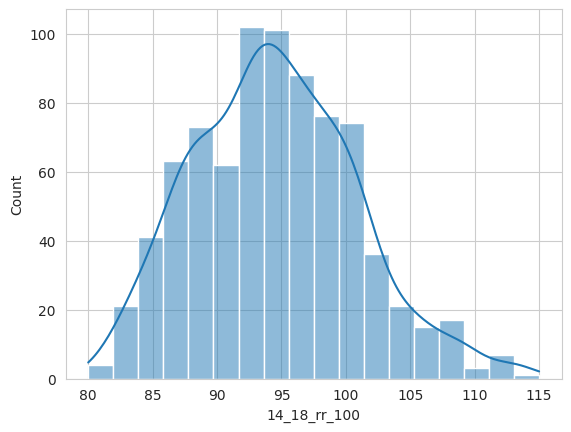

In [ ]:
# check the distribution of the y variable
sns.set_style("whitegrid")
sns.histplot(gdf_SVI[disease_variable_100], kde=True)

In [146]:
import matplotlib.colors as mcolors

# plot the original data based on classification
def plot_with_classes(bin, labels, gdf, variable, colors, title):
  fig, ax = plt.subplots(1, 1, figsize=(15, 5))

  gdf_SVI['category'] = pd.cut(gdf_SVI[variable], bins=bins, labels=labels, include_lowest=True)

  # Create a color map
  cmap = mcolors.ListedColormap(colors)
  # colormap = plt.colormaps[color]  # Adjust the number to match the number of labels

  # Plotting
  gdf_SVI.plot(ax=ax, column='category', cmap=cmap, legend=True,
                    legend_kwds={'title': title,
                                 'bbox_to_anchor': (0.95, 0.1),  # positions legend outside bottom right
                                 'loc': 'lower left',            # anchor point of the legend
                                 'borderaxespad': 0.},
                    edgecolor='black', linewidth=0.2)

  # ax.set_title('Nitrate Concentration Ranges')
  ax.axis('off')

  plt.show()

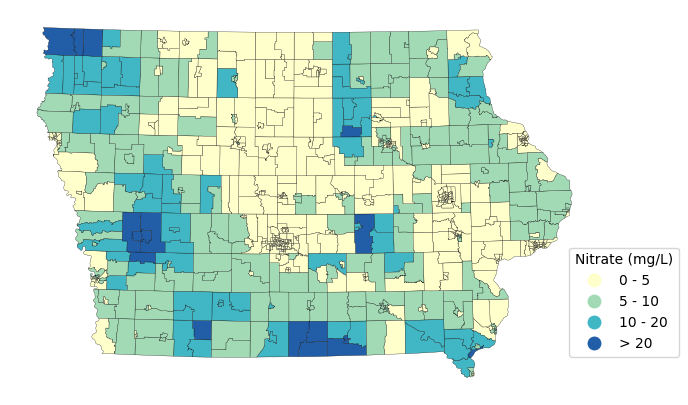

In [149]:
# plot the nitrate concentration data
bins = [0, 5, 10, 20, float('inf')]
labels = ['0 - 5', '5 - 10', '10 - 20', '> 20']
colors = ['#ffffcc', '#a1dab4', '#41b6c4', '#225ea8']
plot_with_classes(bin, labels, gdf_SVI, nitrate_m, colors, 'Nitrate (mg/L)')

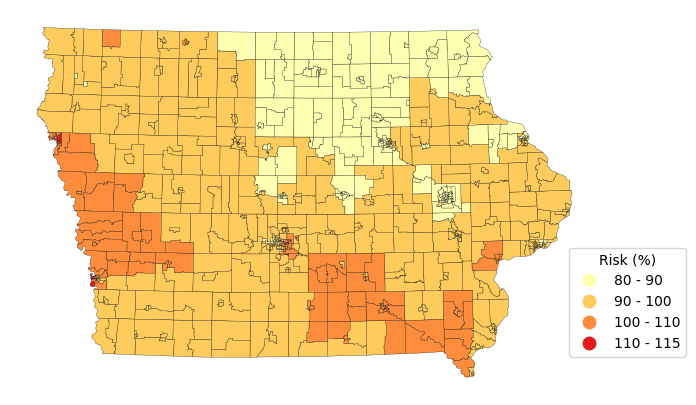

In [150]:
# plot the colorectal cancer risk data
bins = [80, 90, 100, 110, 115]
labels = ['80 - 90', '90 - 100', '100 - 110', '110 - 115']
colors = ['#ffffb2', '#fecc5c', '#fd8d3c', '#e31a1c']
plot_with_classes(bin, labels, gdf_SVI, disease_variable_100, colors, 'Risk (%)')

# Spatial Statistics

### Statistic Preparation

In [113]:
# prepare the variables for statistical model
X = gdf_SVI[X_vars]
X_coords = gdf_SVI[X_vars + ['x_coord','y_coord']]
y = gdf_SVI[disease_variable_100]

In [114]:
# check the correlation of the independent variables
corr = X_coords.corr()
corr.style.background_gradient(cmap='coolwarm')

In [39]:
X_vars_linear = [
 '18_POPDEN',
 '18_QWHITE',
#  '18_QASIAN',
#  '18_QBLACK',
#  '18_QHISP',
#  '18_QNATIVE',
#  '18_QAGED5',
#  '18_QAGED65',
#  '18_QRENTER',
 '18_QUNEMPL',
#  '18_QPOVTY',
#  '18_QSSBEN',
#  '18_QHSEBUR',
#  '18_QNOINSU',
 '18_QESL',
 '18_QNOBD'
 ]
X_vars = X_vars_linear

In [117]:
# selected based on the interpretable result
X_vars_linear = ['18_POPDEN',
 '18_QHISP',
 '18_QNOBD',
 '0418_nmean']
X_vars = X_vars_linear

In [41]:
# @title
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = gdf_SVI[X_vars]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

print(vif_data)

      feature        VIF
0   18_POPDEN   1.609630
1   18_QWHITE  20.965917
2  18_QUNEMPL  11.639146
3     18_QESL   2.091558
4    18_QNOBD  32.652194


### SLM and MGWR

In [40]:
import spreg
from libpysal.weights import Queen

def slm(x, y, gdf):
  X = gdf[x]
  Y = gdf[y]
  w = Queen.from_dataframe(gdf)
  w.transform = 'R'

  slm = spreg.ML_Lag(Y.values, X.values, w=w, name_y='y', name_x=x)

  print(slm.summary)

In [42]:
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW
# %%time
def get_MGWR(x, y, gdf):

  X = gdf[x]
  Y = gdf[y]
  coords = gdf[variables_coord].values
  #Data Mean centering
  y_std = Y
  X_std = (X - X.mean(axis=0))

  sel = Sel_BW(coords,y_std.values.reshape(-1,1),X_std.values,multi=True)
  print(sel)
  bws = sel.search(verbose=False)
  result = MGWR(coords,y_std.values.reshape(-1,1),X_std.values,selector=sel).fit()
  result.summary()
  return result

In [43]:
slm(X_vars, disease_variable_100, gdf_SVI)

<ipython-input-40-a4eca6414b10>:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :           y                Number of Observations:         805
Mean dependent var  :     94.5074                Number of Variables   :           7
S.D. dependent var  :      6.3470                Degrees of Freedom    :         798
Pseudo R-squared    :      0.9427
Spatial Pseudo R-squared:  0.0896
Log likelihood      :  -1631.0111
Sigma-square ML     :      2.4260                Akaike info criterion :    3276.022
S.E of regression   :      1.5576                Schwarz criterion     :    3308.858

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

In [119]:
# use selected variables based on the interpretable result
MGWR_result_selected = get_MGWR(X_vars, disease_variable_100, gdf_SVI)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 805
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          27975.740
Log-likelihood:                                                   -2570.416
AIC:                                                               5150.833
AICc:                                                              5152.938
BIC:                                                              22623.067
R2:                                                                   0.136
Adj. R2:                                                              0.132

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [44]:
MGWR_result2 = get_MGWR(X_vars, variables_exposure, gdf_SVI)

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Model type                                                         Gaussian
Number of observations:                                                 805
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          23922.145
Log-likelihood:                                                   -2507.412
AIC:                                                               5026.824
AICc:                                                              5028.964
BIC:                                                              18576.163
R2:                                                                   0.126
Adj. R2:                                                              0.120

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [45]:
# plot the distribution of variables' intercept with significance
def plot_local_est(gwr_results, gdf, x):
  plot_row = math.ceil(len(x)/2)
  fig, ax = plt.subplots(plot_row,2,figsize=(15,20), dpi=300)
  ax = ax.ravel()
  fig.tight_layout()
  cmap = plt.cm.get_cmap("bwr")

  for j in range(len(x)):

    vmin, vmax = gwr_results.params[:,j].min(), gwr_results.params[:,j].max()
    if abs(vmin) > abs(vmax):
      vmax = abs(vmin)
    elif abs(vmax) > abs(vmin):
      vmin = -abs(vmax)

    gdf.plot(ax=ax[j], column=gwr_results.params[:,j], cmap=cmap, vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.2, legend=True)

    # for j in range(len(variables)):
    gwr_filter_t = gwr_results.filter_tvals(alpha=0.05)
    if (gwr_filter_t[:, j] == 0).any():
      gdf[gwr_filter_t[:, j] == 0].plot(color='lightgrey', ax=ax[j], linewidth=0.1, edgecolor='white')

    ax[j].set_title(x[j],fontsize=10)
    ax[j].get_xaxis().set_visible(False)
    ax[j].get_yaxis().set_visible(False)
    plt.axis('off')

<ipython-input-45-3aee886e3f10>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("bwr")


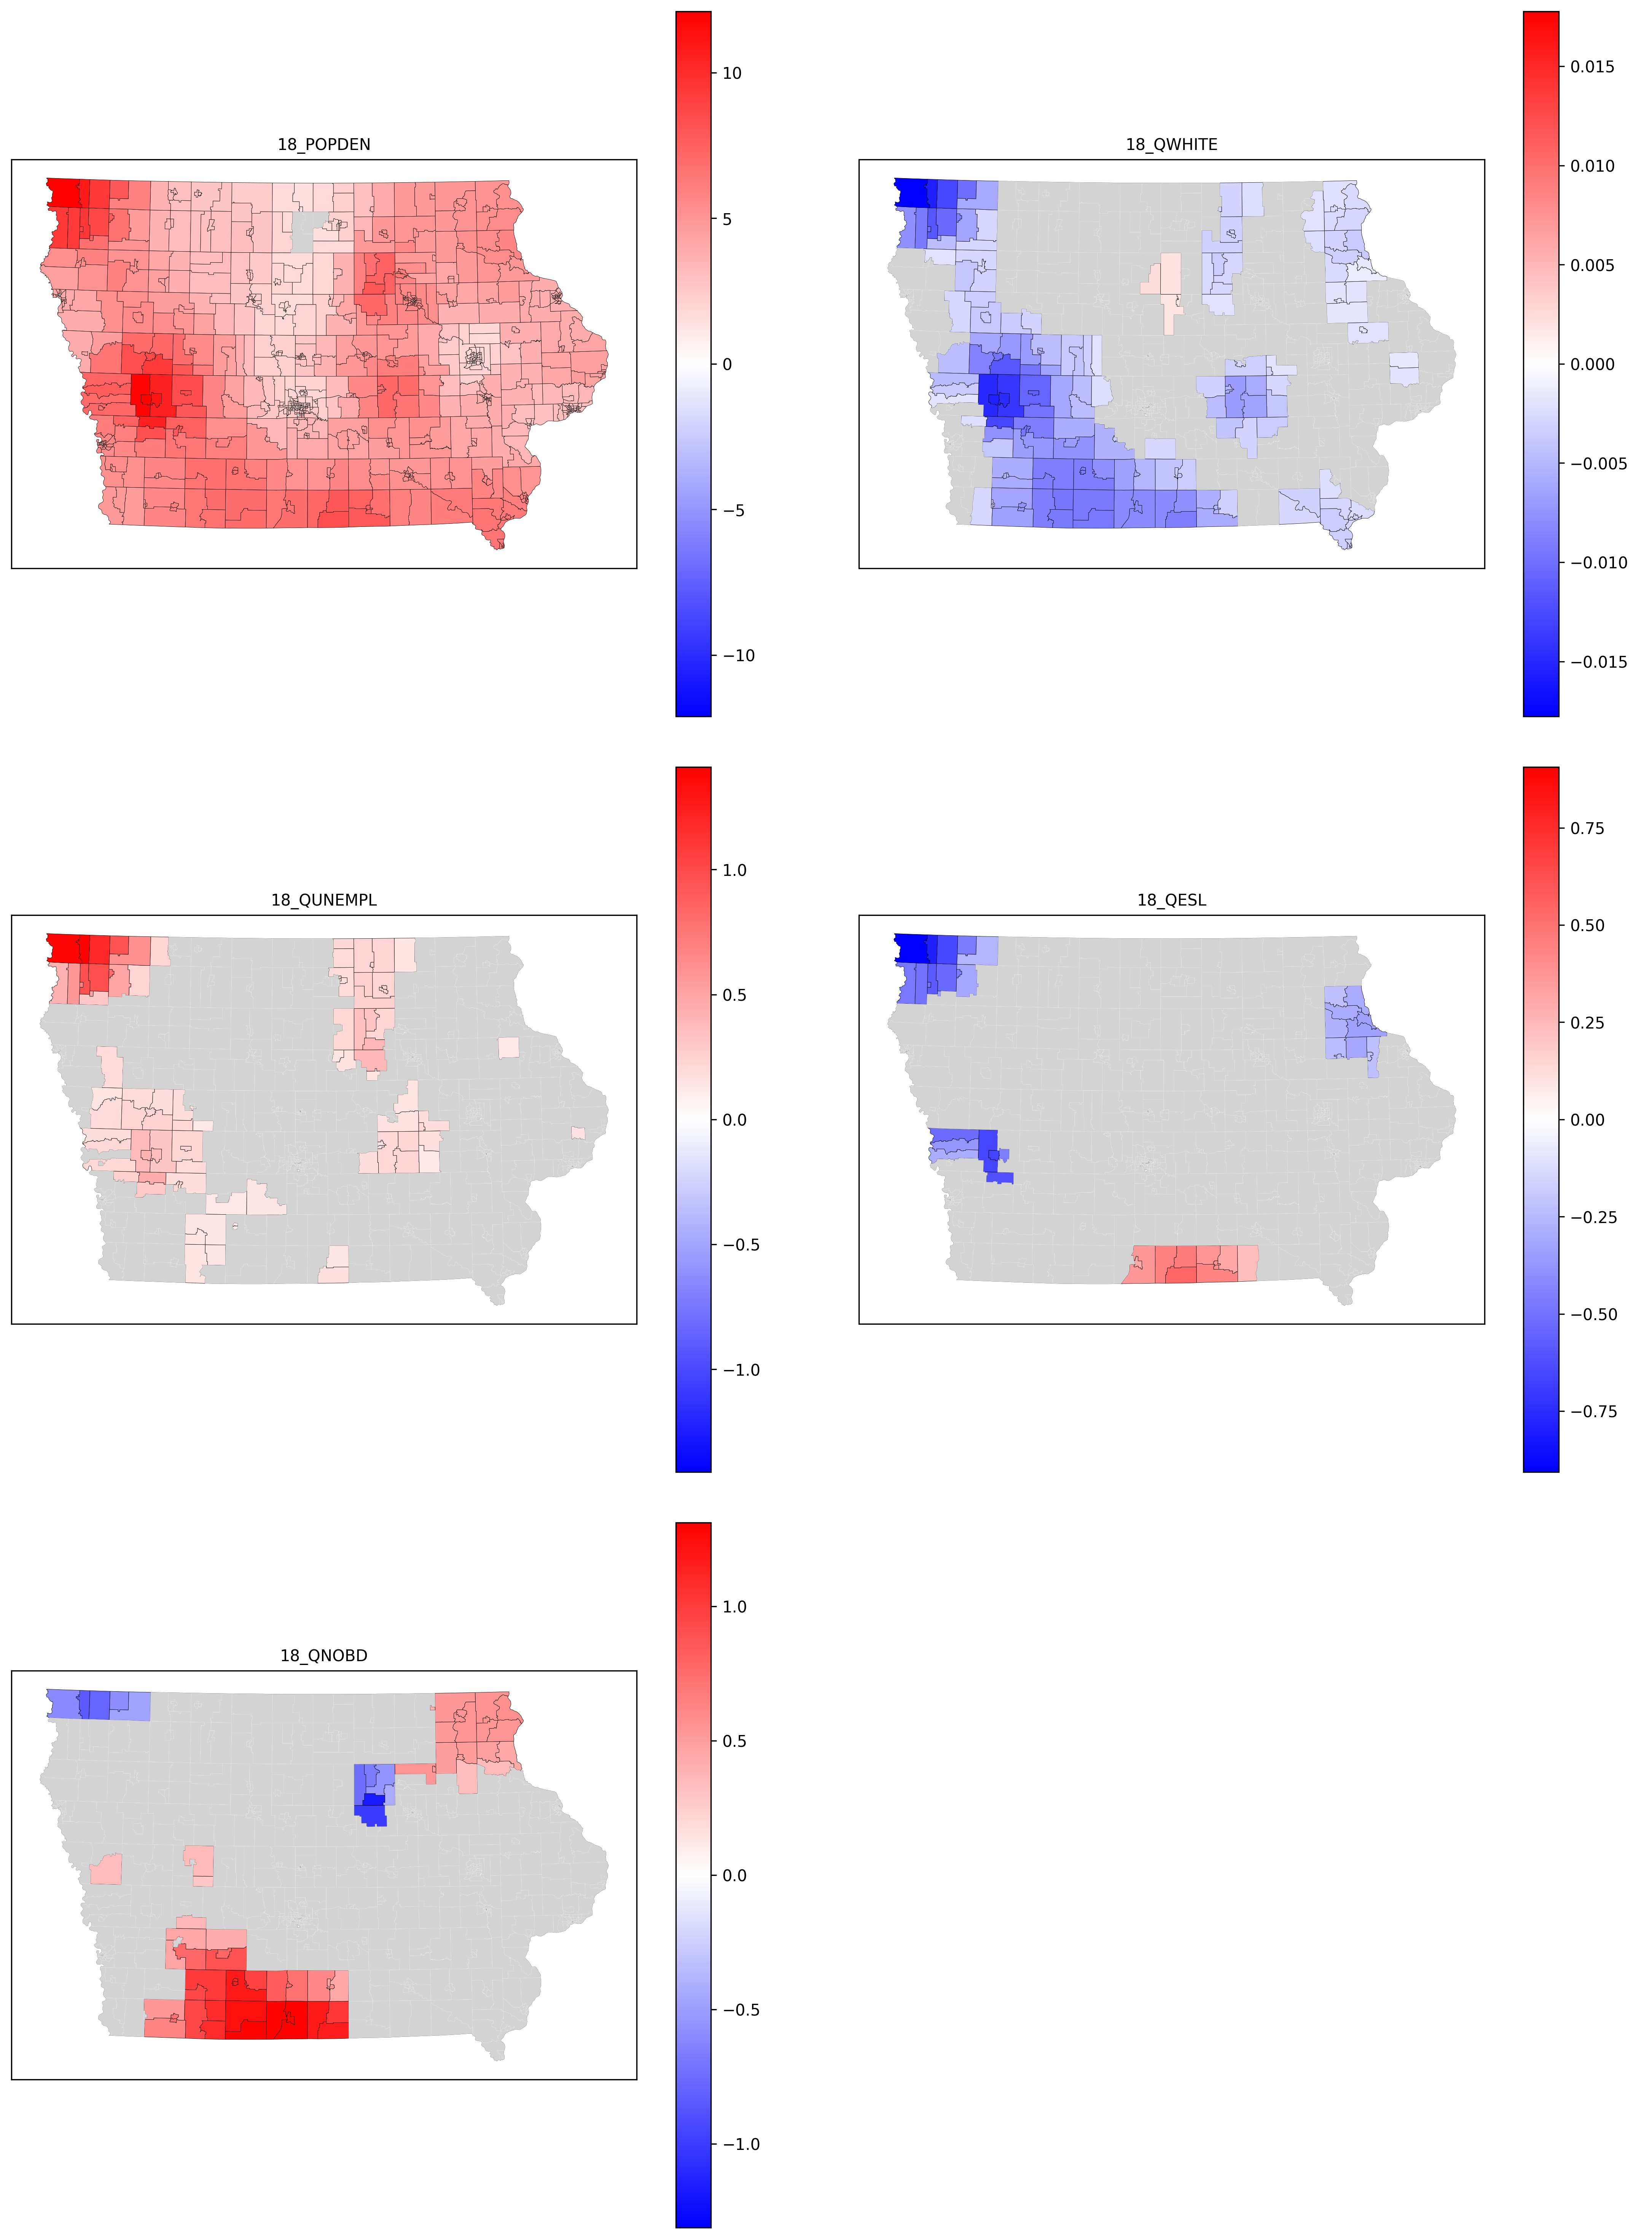

In [46]:
plot_local_est(MGWR_result2, gdf_SVI, X_vars)

<ipython-input-24-3aee886e3f10>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("bwr")


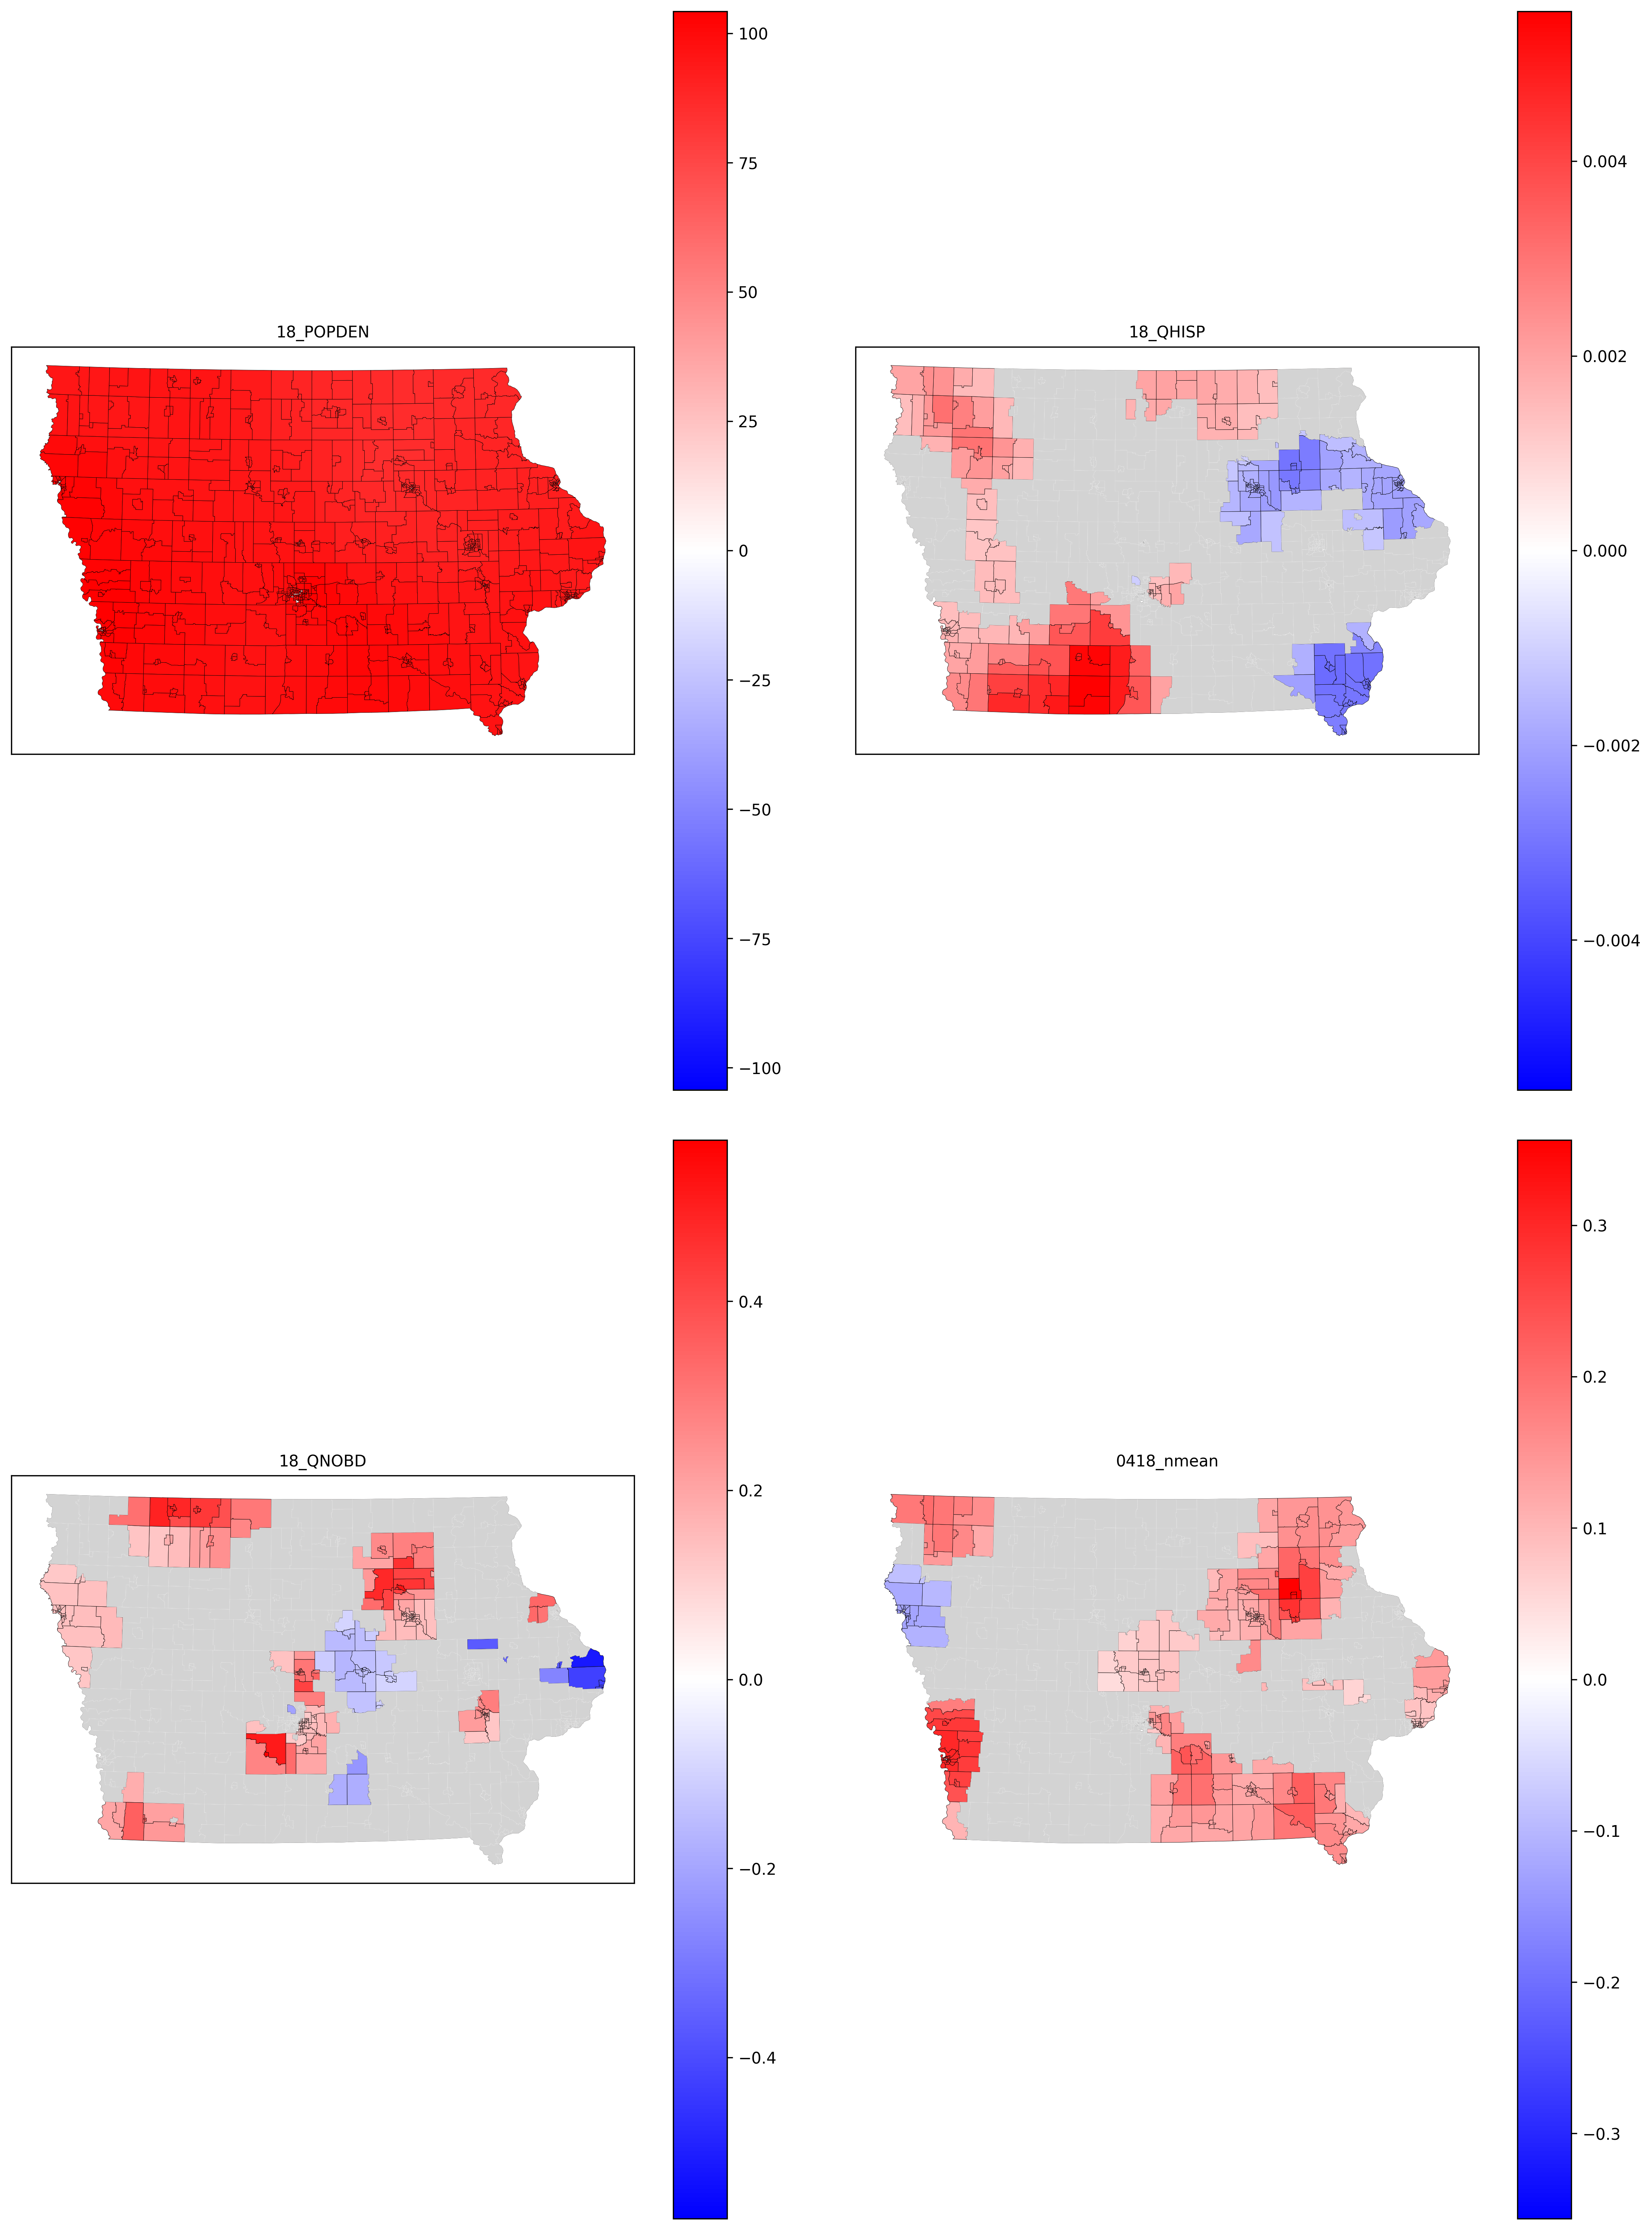

In [120]:
plot_local_est(MGWR_result_selected, gdf_SVI, X_vars)

In [27]:
plot_local_est(MGWR_result1, gdf_SVI, X_vars)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
plot_local_est(MGWR_result, gdf_SVI, X_vars)

Output hidden; open in https://colab.research.google.com to view.

# Machine Learning

### Fit xgboost model

In [15]:
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# train the XGBoost model
def fit_model(x, y, gdf):

  X = gdf[x]
  Y = gdf[y]

  X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                      test_size = 0.2,
                                                      random_state = 222)

  # DMatrix is optimized for both memory efficiency and training speed
  data_test = xgboost.DMatrix(X_test,y_test)

  params = {
      'max_depth': 5,
      'eta': 0.1,
      'objective': 'reg:squarederror',
      'eval_metric': 'rmse'
  }

  data = xgboost.DMatrix(X_train,y_train)
  final_model = xgboost.train(params, data, num_boost_round=500, verbose_eval=False,
                              evals=[(data_test, "Test")],early_stopping_rounds=10)


  data_all = xgboost.DMatrix(X)
  y_pred = final_model.predict(data_all)
  print('y_pred')
  print('Mean Squared Error:', np.sqrt(mean_squared_error(Y, y_pred)))
  print('R2', r2_score(Y, y_pred))

  data_all = xgboost.DMatrix(X)
  y_train_pred = final_model.predict(data)
  print('y_train')
  print('Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_train_pred)))
  print('R2', r2_score(y_train, y_train_pred))

  return final_model

## SHAP analysis of xgboost results

In [2]:
# unlog the log nitrate value
def unlog(value, base_value):
    return (10**value - 1)*100
    # return 10**value

# calculate the variables contribution with shapely    
def shap_value(model, x, gdf, if_unlog='false'):
  X = gdf[x]
  explainer_shap = shap.TreeExplainer(model)
  shap_values = explainer_shap(X)

  # calculate contributions values
  variable_contributions = shap_values.mean(axis=0).values
  print('Variable Mean Contributions', variable_contributions)

  # calculate interaction values
  shap_interaction_values = shap.TreeExplainer(
    model).shap_interaction_values(X)

  if if_unlog == 'true':
    shap_values.values = unlog(shap_values.values, shap_values.base_values[0])
    shap_interaction_values = unlog(shap_interaction_values, shap_values.base_values[0])

  shap.summary_plot(shap_values, X)
  shap.summary_plot(shap_interaction_values, X, max_display=15,plot_type="compact_dot")

  return shap_values, shap_interaction_values, variable_contributions

y_pred
Mean Squared Error: 1.3017714005867398
R2 0.9578812709289579
y_train
Mean Squared Error: 0.8620715240224557
R2 0.981457077541051
Variable Mean Contributions [-0.00254462 -0.00842228 -0.01621053 -0.03486647  0.01175232  0.00563822
  0.00560671 -0.00860947 -0.02671481  0.03789529  0.04395226  0.03101672]


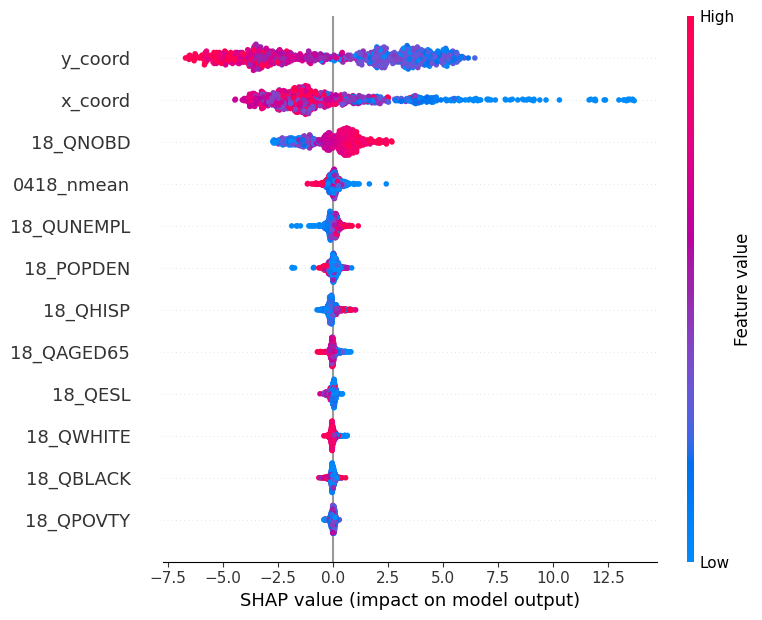

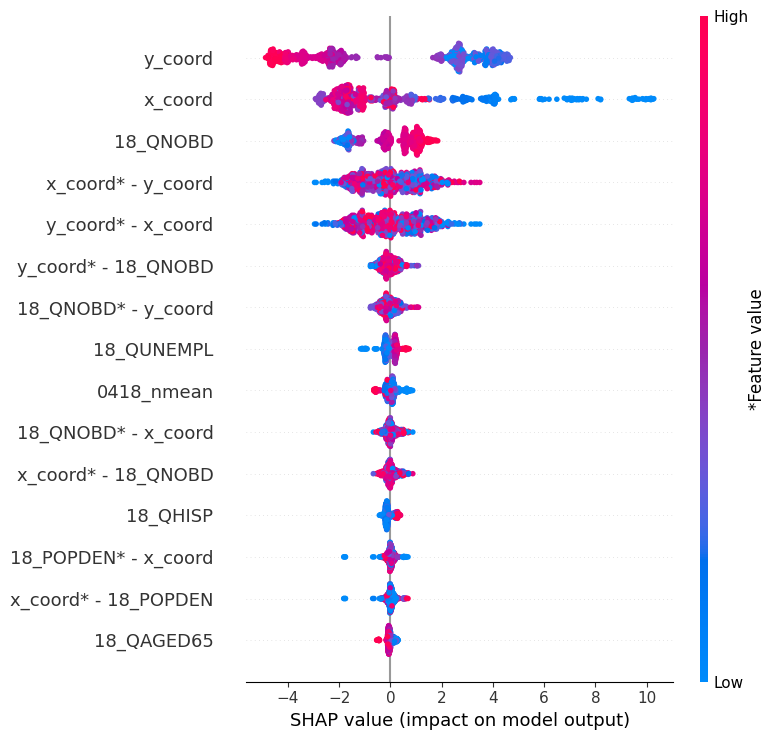

In [183]:
# independent variables: socio-demographic characteristics, coordinates and nitrate concentration
# dependent variables: % colorectal cancer risk 
X_all = variables_SVI+variables_coord+variables_exposure
interaction_model = fit_model(X_all, disease_variable_100, gdf_SVI)
interaction_shap_values, interaction_shap_interaction_values, interaction_variable_contributions = shap_value(interaction_model, X_all, gdf_SVI)

In [156]:
interaction_shap_values.base_values[0]

94.4582

## Global effects

### Summary statistic

In [24]:
# calculate the summary statistics
def summary_stats(x, shap_value):
  df = pd.DataFrame(data = {
      'Feature': x,
      'mean': ['%.4f' % np.mean(shap_value[:,j]) for j in range(len(x))],
      'max': ['%.4f' % np.max(shap_value[:,j]) for j in range(len(x))],
      'min': ['%.4f' % np.min(shap_value[:,j]) for j in range(len(x))],
      '25%': ['%.4f' % np.percentile(shap_value[:,j],[25])[0] for j in range(len(x))],
      '50%': ['%.4f' % np.percentile(shap_value[:,j],[50])[0] for j in range(len(x))],
      '75%': ['%.4f' % np.percentile(shap_value[:,j],[75])[0] for j in range(len(x))]
  })
  return df

In [184]:
summary_df = summary_stats(X_all, interaction_shap_interaction_values[:, -1, :])
summary_df

Feature     mean     max      min      25%      50%     75%
0    18_POPDEN   0.0091  0.4966  -0.2852  -0.0060   0.0093  0.0235
1    18_QWHITE  -0.0027  0.1184  -0.1982  -0.0108  -0.0026  0.0065
2    18_QBLACK   0.0057  0.1123  -0.0663  -0.0042   0.0032  0.0110
3     18_QHISP   0.0021  0.1346  -0.1192  -0.0219   0.0069  0.0208
4   18_QAGED65   0.0007  0.0968  -0.0956  -0.0029   0.0007  0.0041
5   18_QUNEMPL   0.0001  0.0996  -0.1111  -0.0143  -0.0007  0.0174
6    18_QPOVTY  -0.0000  0.0721  -0.0533  -0.0029  -0.0013  0.0038
7      18_QESL   0.0019  0.0668  -0.1145  -0.0011   0.0023  0.0059
8     18_QNOBD  -0.0100  0.2121  -0.2995  -0.0309  -0.0062  0.0162
9      x_coord  -0.0153  0.9490  -0.3033  -0.0768  -0.0121  0.0486
10     y_coord   0.0060  0.6866  -0.3259  -0.0383   0.0018  0.0517
11  0418_nmean   0.0333  0.8675  -0.6484  -0.1059   0.0449  0.1154

### Interaction Metrics

In [27]:
# Get absolute mean of matrices
def interaction_metrics(shap_interaction, x):
  # mean_shap = shap_interaction.mean(0)
  mean_shap = np.abs(shap_interaction).mean(0)
  df = pd.DataFrame(mean_shap, index=x, columns=x)

  # times off diagonal by 2
  df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

  # display
  fig = plt.figure(figsize=(15, 10), facecolor='#002637', edgecolor='r')
  ax = fig.add_subplot()
  sns.heatmap(df.round(decimals=3), cmap='coolwarm', annot=True, fmt='.6g', cbar=False, ax=ax, )
  ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
  ax.tick_params(axis='y', colors='w', labelsize=15)

  plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
  plt.yticks(rotation=0)
  plt.show()

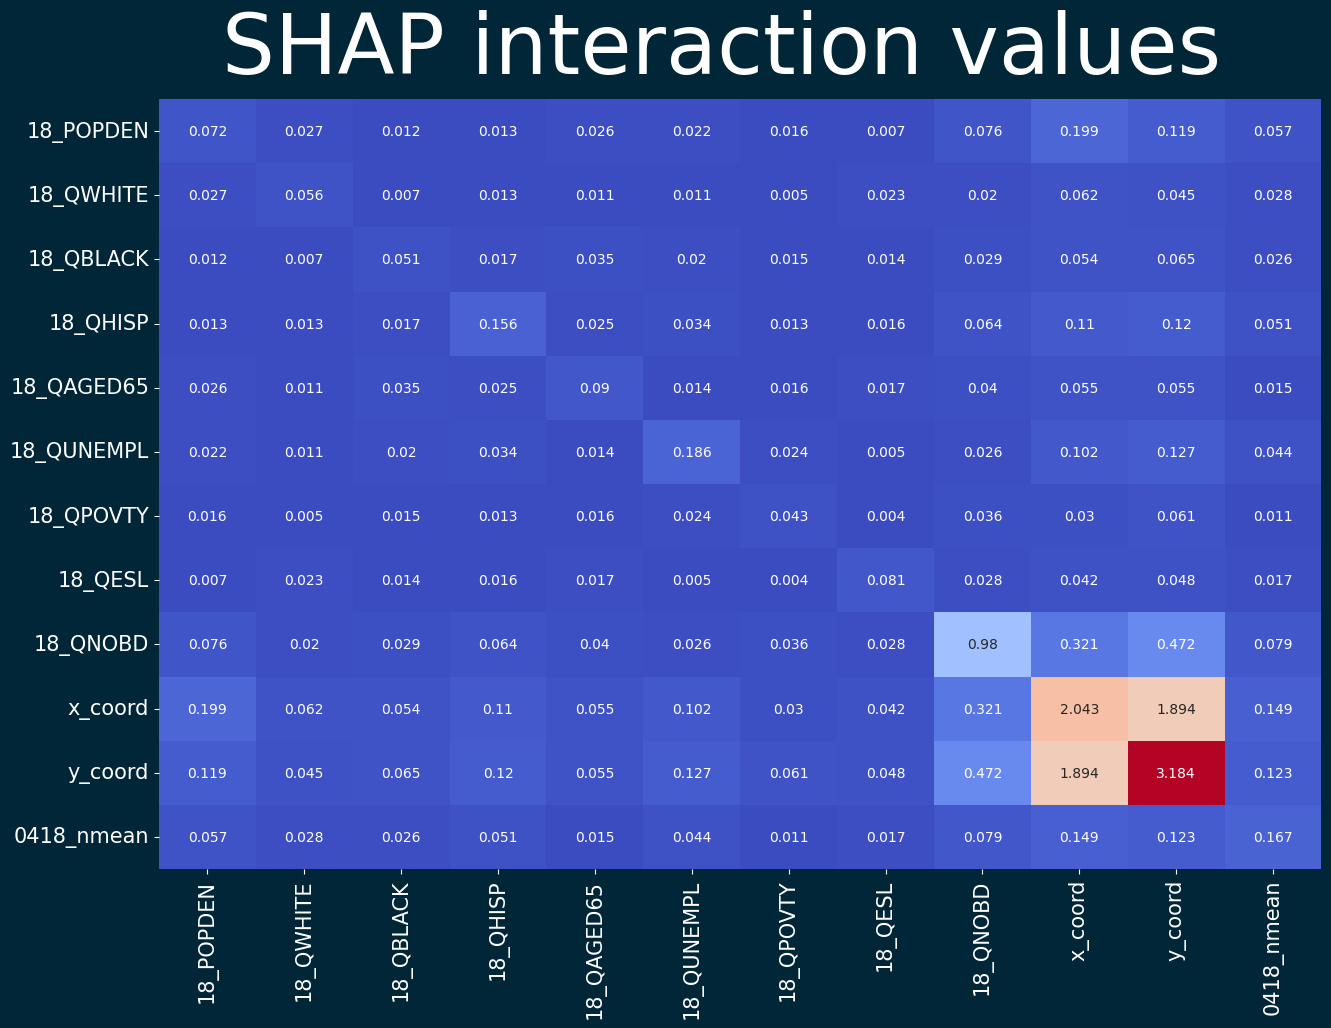

In [185]:
interaction_metrics(interaction_shap_interaction_values, X_all)

## Local effects

### Partial Dependence Plots

In [29]:
!pip install pygam -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 3.4 MB/s eta 0:00:00


In [30]:
from pygam import LinearGAM, s, f
def smoother(X,y):
    lam = np.arange(40,201,20).reshape(-1,1)
    gam = LinearGAM(s(0),fit_intercept=False).gridsearch(X, y, lam=lam)

    for i, term in enumerate(gam.terms):
        XX = gam.generate_X_grid(term=i)
        pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    return XX, pdep,confi

In [31]:
# draw scatter plot for local effect analysis and fit with a Generalized Additive Model
def plot_partial_dependence2(x, gdf, shap_value):
  plot_row = math.ceil(len(x)/2)
  fig, axes = plt.subplots(plot_row, 2,figsize=(15,30),dpi=300)
  axes = axes.flatten()

  for j in range(len(x)):
    ax = axes[j]
    # ipdb.set_trace()
    X = gdf[x]
    df = pd.DataFrame(X.values[:,j],columns=['d'])

    df["shap_val"] = shap_value[:,j]

    sns.scatterplot(ax=ax,x="d", y="shap_val",data=df,color=shap.plots.colors.blue_rgb)

    a,b,confi = smoother(df.d.values.reshape(-1,1),df.shap_val.values.reshape(-1,1))

    ax.plot(a,b,'--', color="red",lw=2)
    ax.plot(a, confi, c='grey', ls='--')
    ax.axhline(y=0, color='black', linestyle='--',lw=1)

    ax.grid(True)
    ax.set_ylabel("SHAP value",fontsize=12)
    ax.set_xlabel("Feature: " + x[j],fontsize=12)

  # Adjust the layout to prevent overlap of labels and titles
  plt.tight_layout()
  plt.show()

In [186]:
plot_partial_dependence2(X_all, gdf_SVI, interaction_shap_values.values)

Output hidden; open in https://colab.research.google.com to view.

In [187]:
plot_partial_dependence2(X_all, gdf_SVI, interaction_shap_interaction_values[:, -1, :])

Output hidden; open in https://colab.research.google.com to view.

### Spatial patterns

In [33]:
# plot the spatial pattern of the feature values and their effects on the predicted variables
def spatial_patterns(x, shap_value, gdf, title):
  plot_row = math.ceil(len(x)/2)
  fig, ax = plt.subplots(plot_row,2,figsize=(15,30),dpi=300)
  fig.tight_layout()
  # ipdb.set_trace()
  for j in range(len(x)):
      ax = ax.ravel()

      vmin, vmax = shap_value[:, j].min(), shap_value[:, j].max()
      if abs(vmin) > abs(vmax):
        vmax = abs(vmin)
      elif abs(vmax) > abs(vmin):
        vmin = -abs(vmax)

      gdf.plot(ax=ax[j],column = shap_value[:, j],legend=True,cmap=shap.plots.colors.red_white_blue, vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.2)

      ax[j].set_title(title + x[j],fontsize=10)
      ax[j].get_xaxis().set_visible(False)
      ax[j].get_yaxis().set_visible(False)
  plt.tight_layout()

In [188]:
spatial_patterns(X_all, interaction_shap_interaction_values[:, -1, :], gdf_SVI, "SHAP of nitrate & ")

Output hidden; open in https://colab.research.google.com to view.

In [189]:
spatial_patterns(X_all, interaction_shap_values.values, gdf_SVI, "SHAP of ")

Output hidden; open in https://colab.research.google.com to view.

### Location Effect Map

In [35]:
# draw the location (x and y coordinates) effects on the predicted variable 
def plot_location_effect(gdf, shap_value):
  fig, ax = plt.subplots(dpi=300, figsize=(15,3))
  vmin, vmax = shap_value.min(), shap_value.max()
  if abs(vmin) > abs(vmax):
    vmax = abs(vmin)
  elif abs(vmax) > abs(vmin):
    vmin = -abs(vmax)
  gdf.plot(ax=ax,column = shap_value, legend=True,figsize=(15,3), cmap=shap.plots.colors.red_white_blue, vmin=vmin, vmax=vmax, edgecolor='black', linewidth=0.1)
  # plt.title("Location Effect on Ride-hailing Trip Demand\n(SHAP values of geographic coordinates)\n",fontsize=8)

  plt.axis('off')

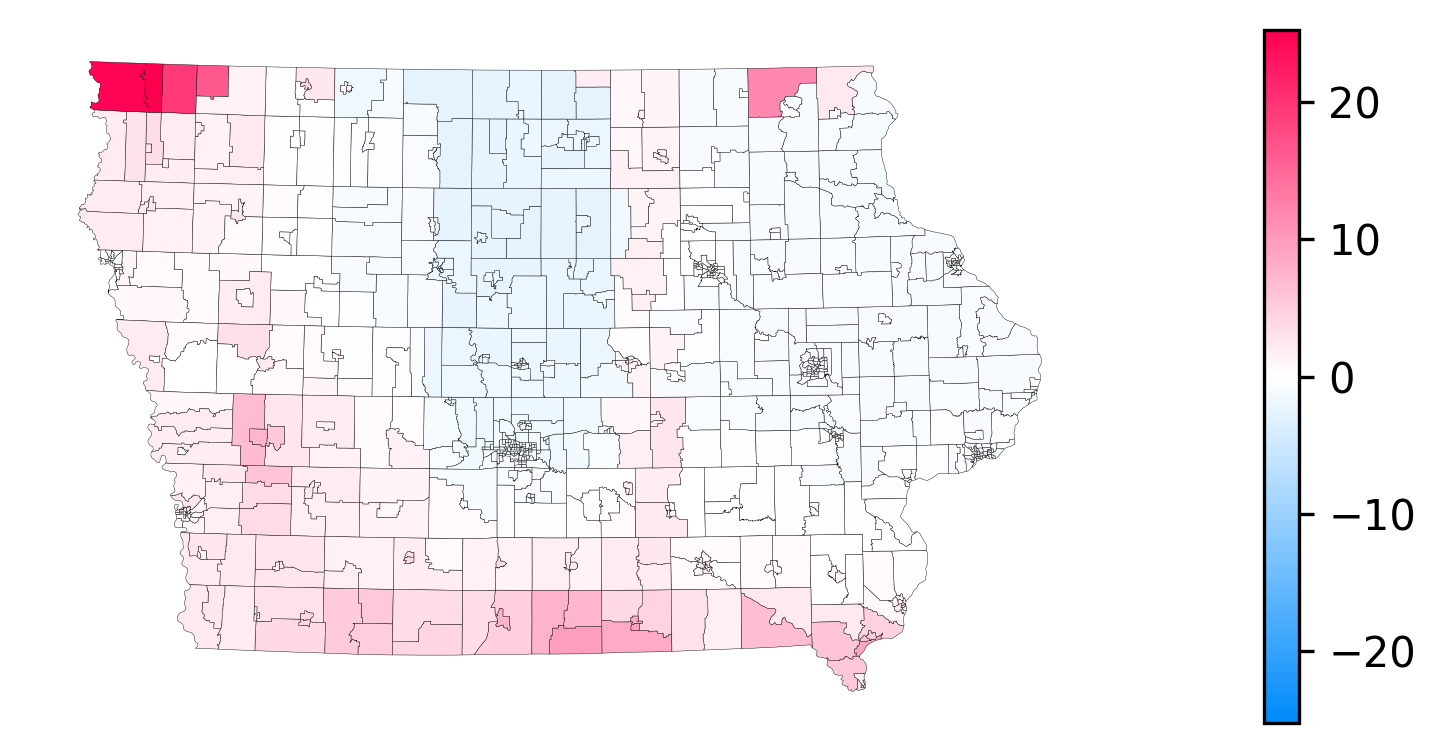

In [36]:
plot_location_effect(gdf_SVI, nitrate_socio_shap_values.values[:,-1] + nitrate_socio_shap_values.values[:,-2])

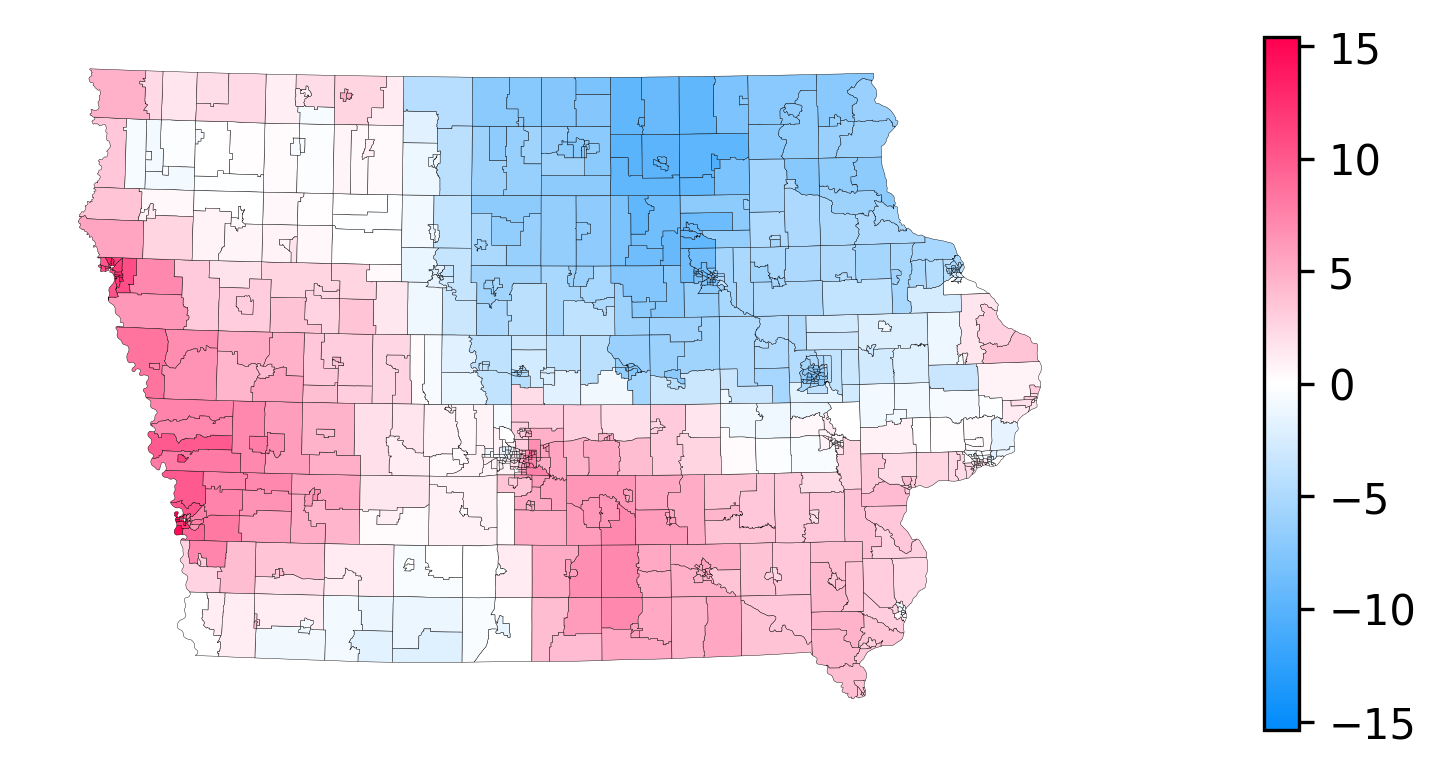

In [174]:
plot_location_effect(gdf_SVI, interaction_shap_values.values[:,-2] + interaction_shap_values.values[:,-3])

## socio + coor -> nitrate
Another experiment on investigating social vulnerability and nitrate exposure

y_pred
Mean Squared Error: 2.653072497868539
R2 0.7929205401285312
y_train
Mean Squared Error: 2.0779654407906096
R2 0.8839722196708228
Variable Mean Contributions [-0.16670339 -0.02762896  0.00900965  0.04854937 -0.00926911 -0.03623777
 -0.02387658  0.03001821  0.1759335  -0.04012047  0.02790395  0.07368083]


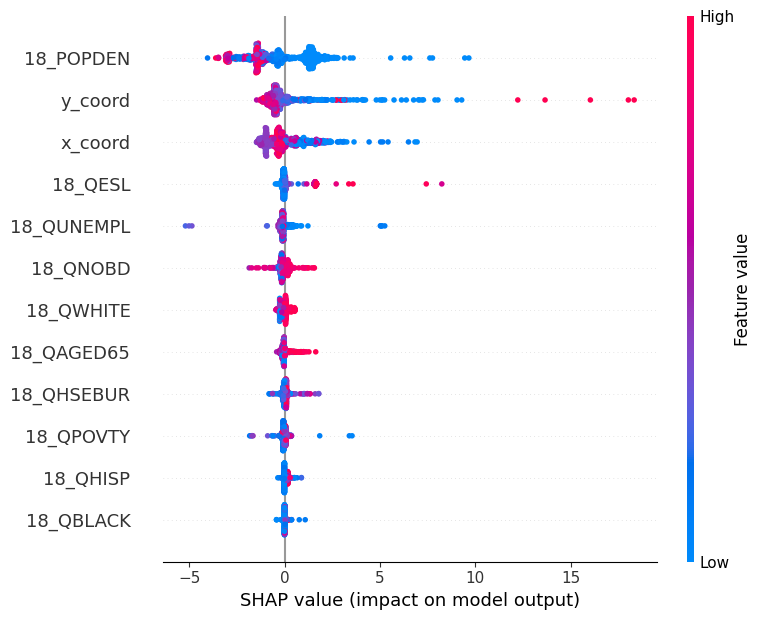

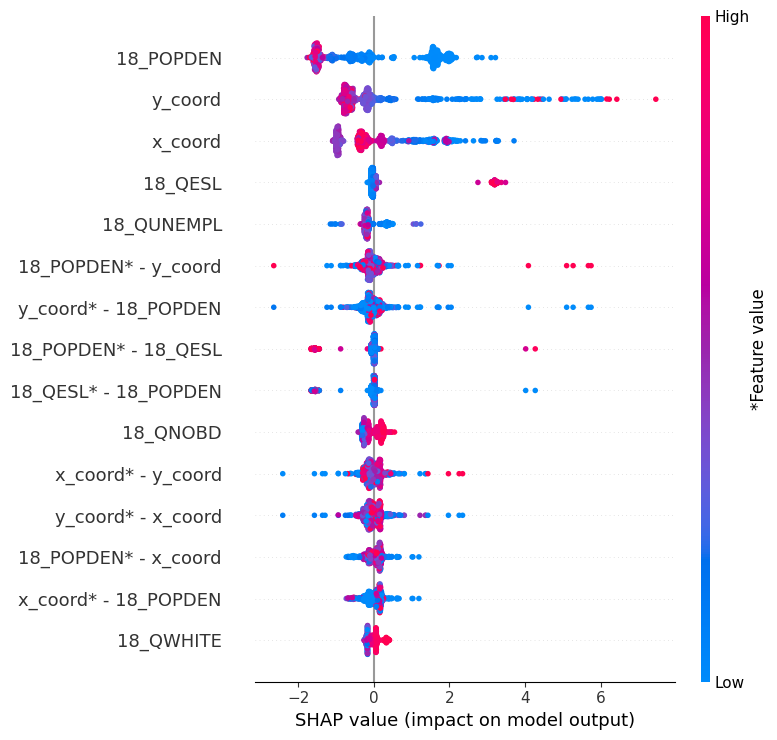

In [38]:

variables_SVI = [
 '18_POPDEN',
 '18_QWHITE',
#  '18_QASIAN',
 '18_QBLACK',
 '18_QHISP',
#  '18_QNATIVE',
#  '18_QAGED5',
 '18_QAGED65',
#  '18_QRENTER',
 '18_QUNEMPL',
 '18_QPOVTY',
#  '18_QSSBEN',
 '18_QHSEBUR',
#  '18_QNOINSU',
 '18_QESL',
 '18_QNOBD'
 ]
# independent variables: socio-demographic characteristics and coordinates
# dependent variables: nitrate concentration
X_all = variables_SVI+variables_coord
nitrate_socio_model = fit_model(X_all, variables_exposure, gdf_SVI)
nitrate_socio_shap_values, nitrate_socio_shap_interaction_values, nitrate_socio_variable_contributions = shap_value(nitrate_socio_model, X_all, gdf_SVI, if_unlog='false')

In [193]:
nitrate_socio_shap_values.base_values[0]

5.3594613

In [25]:
summary_df = summary_stats(X_all, nitrate_socio_shap_values.values)
summary_df

Feature     mean      max      min      25%      50%      75%
0    18_POPDEN  -0.1667   9.6654  -4.0484  -1.4154  -0.3629   1.3214
1    18_QWHITE  -0.0276   0.5516  -0.4645  -0.1474  -0.0355   0.0546
2    18_QBLACK   0.0090   1.0783  -0.4321  -0.0049   0.0047   0.0185
3     18_QHISP   0.0485   0.8785  -0.3608  -0.0221   0.0022   0.1286
4   18_QAGED65  -0.0093   1.6295  -0.4221  -0.1046  -0.0489  -0.0064
5   18_QUNEMPL  -0.0362   5.2528  -5.2069  -0.1362  -0.0958  -0.0606
6    18_QPOVTY  -0.0239   3.5361  -1.8370  -0.0737  -0.0306   0.0371
7   18_QHSEBUR   0.0300   1.7869  -0.8231  -0.0467   0.0065   0.0814
8      18_QESL   0.1759   8.2452  -0.4877  -0.0559  -0.0251   0.0277
9     18_QNOBD  -0.0401   1.5577  -1.8625  -0.1637  -0.0788   0.1147
10     x_coord   0.0279   6.9493  -1.4789  -0.7459  -0.2504   0.5322
11     y_coord   0.0737  18.3391  -1.4720  -0.6000  -0.4040  -0.0045

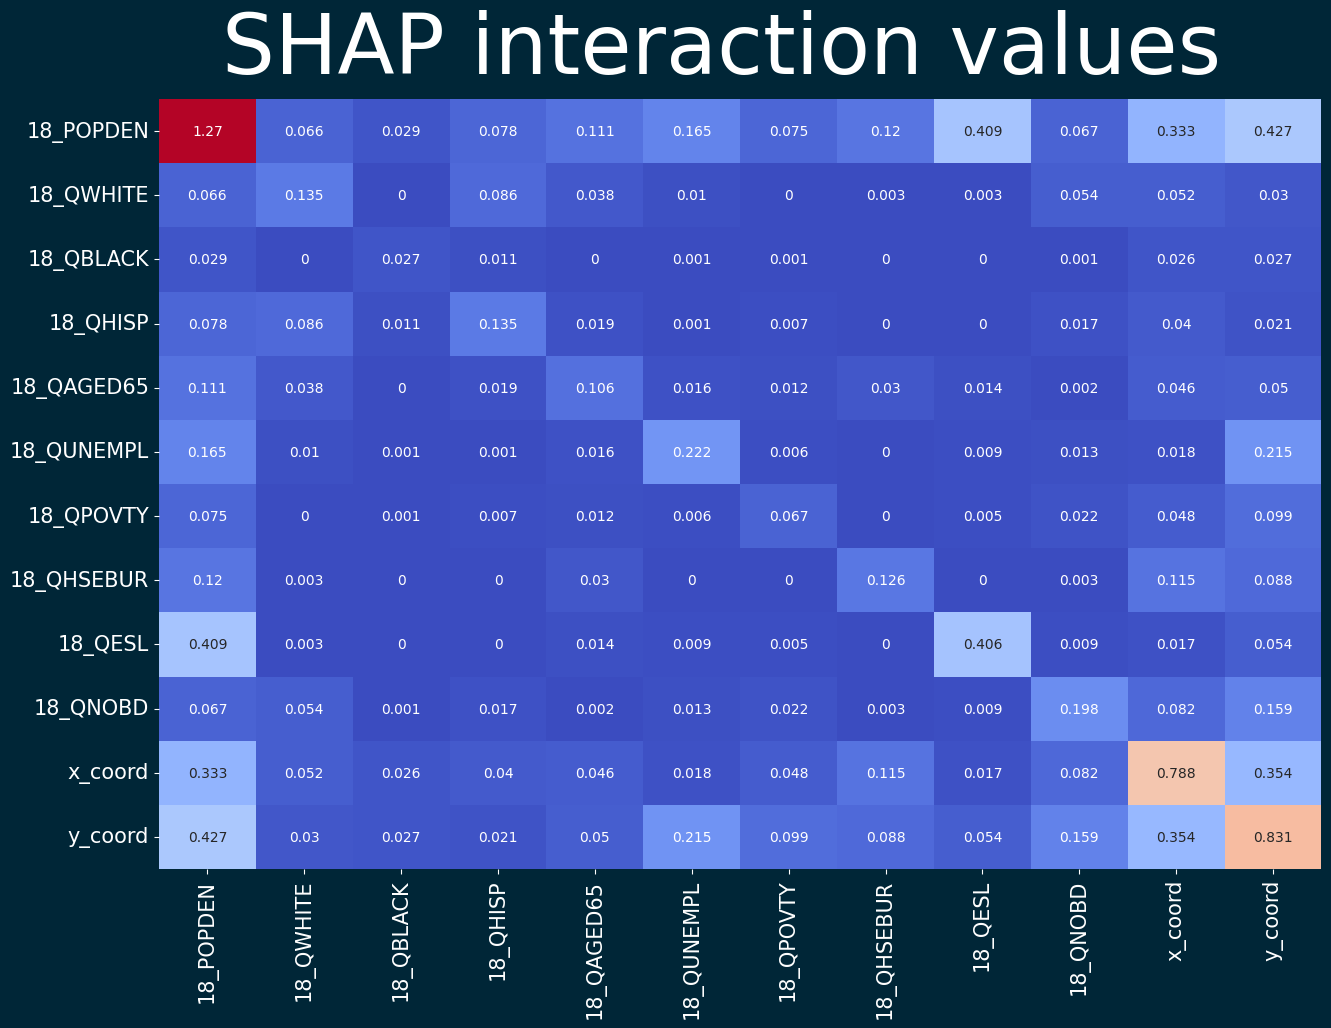

In [28]:
interaction_metrics(nitrate_socio_shap_interaction_values, X_all)

In [32]:
plot_partial_dependence2(X_all, gdf_SVI, nitrate_socio_shap_values.values)

Output hidden; open in https://colab.research.google.com to view.

In [34]:
spatial_patterns(X_all, nitrate_socio_shap_values.values, gdf_SVI, "SHAP of ")

Output hidden; open in https://colab.research.google.com to view.